In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("hf://datasets/majeedkazemi/students-coding-questions-from-ai-assistant/students-coding-questions-from-ai-assistant.csv")
df.to_csv('/content/drive/MyDrive/DLTeamProject/programming_questions.csv', index=False)

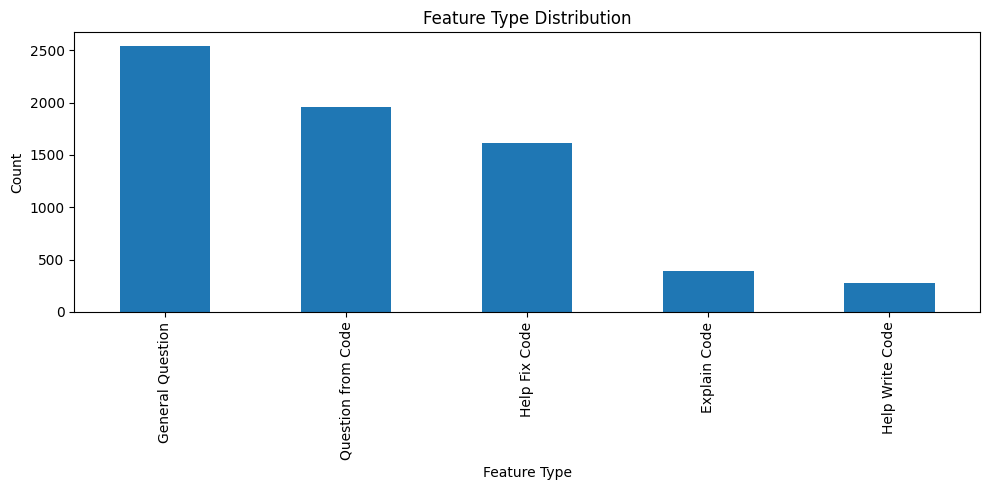

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/DLTeamProject/programming_questions.csv')

df['feature_type'].value_counts().plot(kind='bar', figsize=(10, 5), title='Feature Type Distribution')
plt.xlabel('Feature Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [11]:
df_balanced = df.groupby('feature_type').apply(
    lambda x: x.sample(n=min(4000, len(x)), random_state=42)
).reset_index(drop=True)

print(df_balanced['feature_type'].value_counts())

feature_type
General Question      2544
Question from Code    1954
Help Fix Code         1611
Explain Code           387
Help Write Code        280
Name: count, dtype: int64


<ipython-input-11-e86d9116c218>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('feature_type').apply(


In [3]:
!pip install sentence-transformers

In [12]:
from sentence_transformers import SentenceTransformer

df_balanced['input_question'] = df_balanced['input_question'].fillna(df_balanced['input_task_description']).fillna(df_balanced['input_intention']).fillna('')
df_balanced['input_code'] = df_balanced['input_code'].fillna('')
df_balanced['combined'] = df_balanced['input_question'] + df_balanced['input_code']

# model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('all-roberta-large-v1')

embeddings = model.encode(df_balanced['combined'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/212 [00:00<?, ?it/s]

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X = embeddings
y = df_balanced['feature_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=10, kernel='rbf'))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

      Explain Code       0.75      0.77      0.76        78
  General Question       0.92      0.96      0.94       509
     Help Fix Code       0.87      0.86      0.87       322
   Help Write Code       0.69      0.52      0.59        56
Question from Code       0.89      0.88      0.89       391

          accuracy                           0.88      1356
         macro avg       0.83      0.80      0.81      1356
      weighted avg       0.88      0.88      0.88      1356



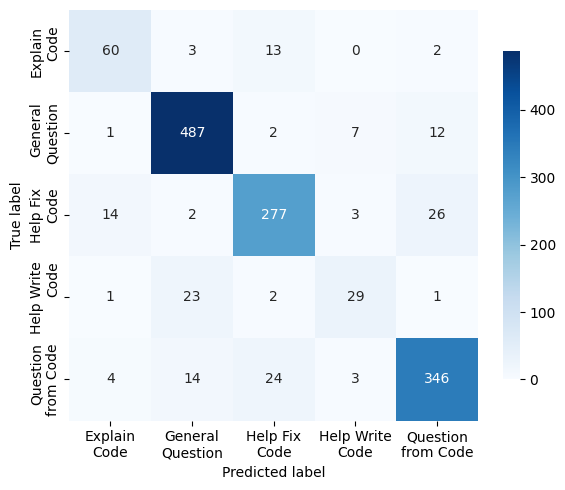

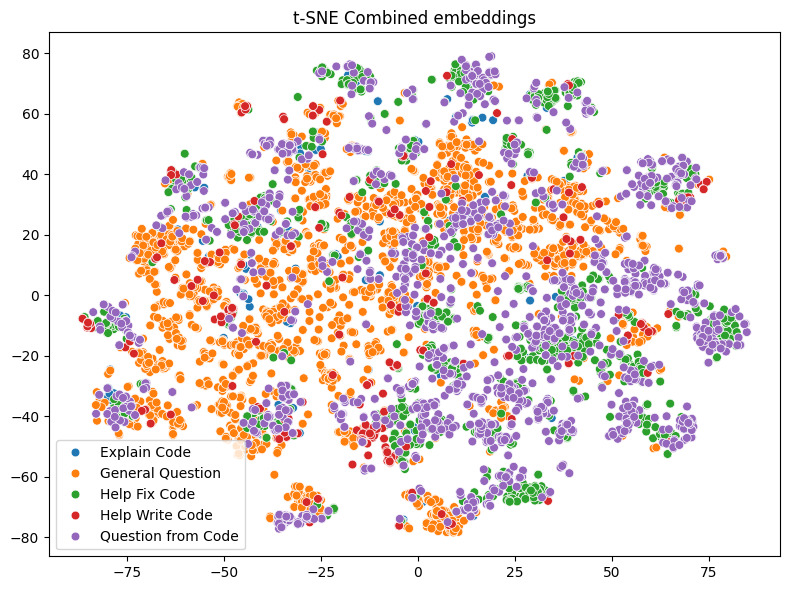

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
labels = ["Explain\nCode",
          "General\nQuestion",
          "Help Fix\nCode",
          "Help Write\nCode",
          "Question\nfrom Code"]

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            cbar_kws={"shrink": 0.8},
            ax=ax)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

from sklearn.manifold import TSNE
import seaborn as sns

# Embeddings to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=y, palette="tab10", s=40)
plt.title("t-SNE Combined embeddings")
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [15]:
!pip install -U transformers

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from datasets import Dataset, load_metric
from transformers import TrainingArguments

df = pd.read_csv('/content/drive/MyDrive/DLTeamProject/programming_questions.csv')

df['text'] = (
    df['input_question']
    .fillna(df['input_task_description'])
    .fillna(df['input_intention'])
    .fillna('')
) + "\n\n" + df['input_code'].fillna('')

df['label'] = df['feature_type'].astype('category').cat.codes
label_list = df['feature_type'].astype('category').cat.categories.tolist()
label_map = {label: i for i, label in enumerate(label_list)}

df = df.groupby('feature_type', group_keys=False).apply(
    lambda x: x.sample(n=min(250, len(x)), random_state=42)
).reset_index(drop=True)

train_df, test_df = train_test_split(df[['text', 'label']], test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_list), device_map="auto")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

metric = load_metric("f1")

from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=-1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1": f1}

args = TrainingArguments(
    output_dir="./bert-classifier",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

trainer.train()
preds = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), dim=1)

<ipython-input-12-30f30e23f9d8>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('feature_type', group_keys=False).apply(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

<ipython-input-12-30f30e23f9d8>:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.919100,0.837145,0.580714
2,0.660600,0.599502,0.799853
3,0.443400,0.438368,0.887632


<Figure size 600x600 with 0 Axes>

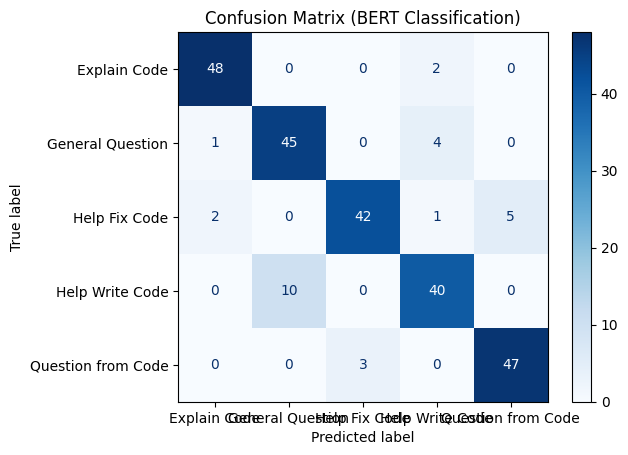

                    precision    recall  f1-score   support

      Explain Code       0.94      0.96      0.95        50
  General Question       0.82      0.90      0.86        50
     Help Fix Code       0.93      0.84      0.88        50
   Help Write Code       0.85      0.80      0.82        50
Question from Code       0.90      0.94      0.92        50

          accuracy                           0.89       250
         macro avg       0.89      0.89      0.89       250
      weighted avg       0.89      0.89      0.89       250



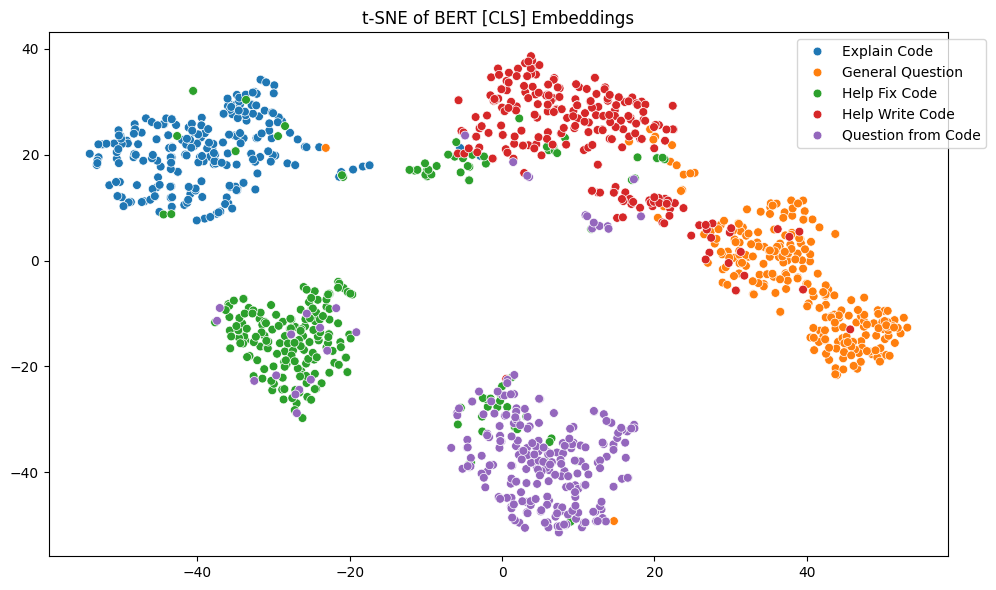

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(df_preds["true_label"], df_preds["predicted_label"], labels=label_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (BERT Classification)")
plt.show()

print(classification_report(df_preds["true_label"], df_preds["predicted_label"]))
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

with torch.no_grad():
    inputs = tokenizer(df['text'].tolist(), return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
    outputs = model.bert(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

y = df['feature_type'].values

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(cls_embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y, palette="tab10", s=40)
plt.title("t-SNE of BERT [CLS] Embeddings")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [ ]:
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from datasets import Dataset, load_metric
from transformers import TrainingArguments

df = pd.read_csv('/content/drive/MyDrive/DLTeamProject/programming_questions.csv')

df['text'] = (
    df['input_question']
    .fillna(df['input_task_description'])
    .fillna(df['input_intention'])
    .fillna('')
) + "\n\n" + df['input_code'].fillna('')

df['label'] = df['feature_type'].astype('category').cat.codes
label_list = df['feature_type'].astype('category').cat.categories.tolist()
label_map = {label: i for i, label in enumerate(label_list)}

df = df.groupby('feature_type', group_keys=False).apply(
    lambda x: x.sample(n=min(4000, len(x)), random_state=42)
).reset_index(drop=True)

train_df, test_df = train_test_split(df[['text', 'label']], test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_list), device_map="auto")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

metric = load_metric("f1")

from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=-1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1": f1}

args = TrainingArguments(
    output_dir="./bert-classifier",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

trainer.train()
preds = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), dim=1)

<ipython-input-16-74f71def744a>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('feature_type', group_keys=False).apply(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5420 [00:00<?, ? examples/s]

Map:   0%|          | 0/1356 [00:00<?, ? examples/s]

<ipython-input-16-74f71def744a>:40: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


<ipython-input-16-74f71def744a>:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.242000,0.343652,0.883980
2,0.211200,0.311063,0.907654
3,0.175900,0.301447,0.910190


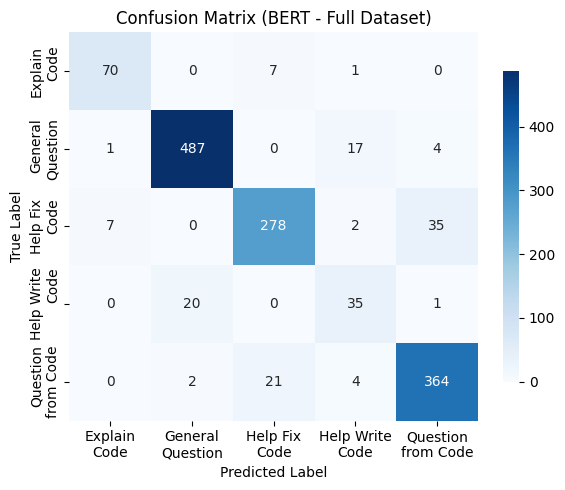

100%|██████████| 106/106 [00:53<00:00,  1.99it/s]


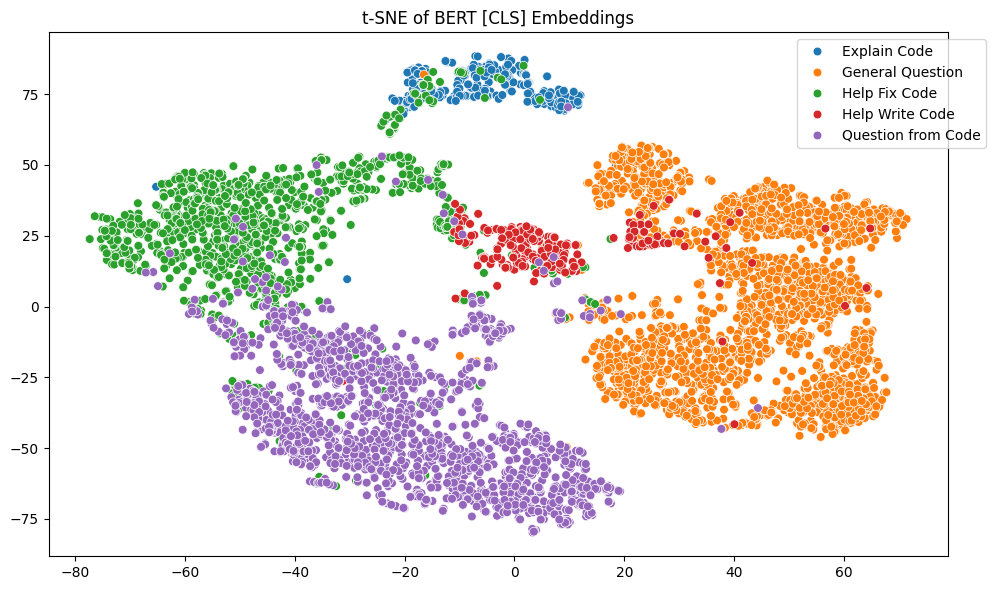

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import torch

label_indices = list(range(len(label_list)))

labels_wrapped = ["Explain\nCode",
                  "General\nQuestion",
                  "Help Fix\nCode",
                  "Help Write\nCode",
                  "Question\nfrom Code"]

cm = confusion_matrix(pred_df["true_label"], pred_df["predicted_label"], labels=label_indices)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_wrapped,
            yticklabels=labels_wrapped,
            cbar_kws={"shrink": 0.8},
            ax=ax)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.xticks(rotation=0)
plt.title("Confusion Matrix (BERT - Full Dataset)")
plt.tight_layout()
plt.show()

from tqdm import tqdm

batch_size = 64
texts = df['text'].tolist()
cls_embeddings = []

model.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
        outputs = model.bert(**inputs)
        cls = outputs.last_hidden_state[:, 0, :].cpu()
        cls_embeddings.append(cls)

cls_embeddings = torch.cat(cls_embeddings).numpy()

y = df['feature_type'].values

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(cls_embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y, palette="tab10", s=40)
plt.title("t-SNE of BERT [CLS] Embeddings")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [31]:
print(classification_report(pred_df["true_label"], pred_df["predicted_label"]))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        78
           1       0.96      0.96      0.96       509
           2       0.91      0.86      0.89       322
           3       0.59      0.62      0.61        56
           4       0.90      0.93      0.92       391

    accuracy                           0.91      1356
   macro avg       0.85      0.85      0.85      1356
weighted avg       0.91      0.91      0.91      1356

